In [12]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import numpy as np
import operator
import matplotlib.pyplot as plt
from functools import reduce
from torchvision import datasets, transforms
from PIL import Image

%matplotlib inline

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Use CUDA if it is available
num_channels = 5 # Number of channels used as input
batch_size = 4 # Batch size of the experiment

## Defining the training process and architecture

In [14]:
def prod(iterable):
    return reduce(operator.mul, iterable, 1)
  
class NetCNN(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        if (len(input_shape) != 3):
            raise ValueError('Expecting an input_shape representing dimensions CxHxW')
        self._input_channels = input_shape[0]
        print('input_channels: {}'.format(self._input_channels))
        self._conv2d1 = nn.Conv2d(in_channels=self._input_channels, out_channels=64, kernel_size=3)
        self._conv2d2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self._cnn_output_dim = self._cnn(torch.zeros(input_shape).unsqueeze(0)).nelement()
        print('cnn_output_dim: {}'.format(self._cnn_output_dim))
        self._fc1 = nn.Linear(self._cnn_output_dim, 256)
        self._fc2 = nn.Linear(256, output_dim)
        
    def _cnn(self, x):
        x = self._conv2d1(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        x = self._conv2d2(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        return x
    
    
    def forward(self, x):
        batch_dim = x.shape[0]
        x = self._cnn(x).view(batch_dim, -1)
        x = self._fc1(x)
        x = torch.relu(x)
        x = self._fc2(x)
        x = torch.sigmoid(x)
        return x
    
class NetFF(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        if (len(input_shape) != 3):
            raise ValueError('Expecting an input_shape representing dimensions CxHxW')
        self._input_channels = input_shape[0]
        print('input_channels: {}'.format(self._input_channels))
        self._input_dim = prod(input_shape)
        print('input_dim: {}'.format(self._input_dim))
        self._fc1 = nn.Linear(self._input_dim, 64)
        self._fc2 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = x.view(-1, self._input_dim)
        x = self._fc1(x)
        x = torch.relu(x)
        x = self._fc2(x)
        x = torch.sigmoid(x)
        return x

def run_experiment(name, sun_maker_func, debug_out=False):
    sun = sun_maker_func(num_channels)
    sun_numpy = sun.cpu().numpy()

    if debug_out:
        for channel in sun_numpy:
            plt.imshow(channel, norm=None, cmap='hot', vmin=sun_numpy.min(), vmax=sun_numpy.max())
            plt.show()

    model = NetCNN(input_shape=[num_channels, 28, 28], output_dim=num_channels)
    model.cuda(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters())

    losses = []
    for b in range(1000):
        data = torch.cat([sun_maker_func(num_channels=num_channels) for i in range(batch_size)]).view(batch_size, num_channels, 28, 28)
        data_min, data_max = torch.min(data), torch.max(data)
        dim_factors = torch.rand(batch_size, num_channels).view(batch_size,-1).to(device)
  #       print(batch.shape)
  #       print(dim_factors.shape)
        dimmed_data = data.clone().to(device)
        for i in range(batch_size):
            for j in range(num_channels):
                dimmed_data[i, j] *= dim_factors[i, j]

        optimizer.zero_grad()
        output = model(dimmed_data)
        loss = nn.MSELoss()(output, dim_factors)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))

        if b % 10 == 0:
            print('Current loss: {}'.format(float(loss)))
            sample = data[0].cpu().numpy()
            sample_dimmed = dimmed_data[0].cpu().numpy()

            if debug_out:
                for i, (channel, channel_dimmed) in enumerate(zip(sample, sample_dimmed)):
                    fig = plt.figure()
                    ax1 = fig.add_subplot(1, 3, 1)
                    ax1.imshow(channel, norm=None, cmap='hot', vmin=data_min, vmax=data_max)
                    ax2 = fig.add_subplot(1, 3, 2)
                    ax2.imshow(channel_dimmed, norm=None, cmap='hot', vmin=data_min, vmax=data_max)
                    ax3 = fig.add_subplot(1, 3, 3)
                    ax3.imshow(channel_dimmed / float(output[0, i]), norm=None, cmap='hot', vmin=data_min, vmax=data_max)
                    print('Channel: {} (left: original, middle: dimmed, right: undimmed)\nDimming (true): {}, dimming (predicted): {}'.format(i, dim_factors[0, i], output[0, i]))
                    plt.show()
                dim_factors_numpy = dim_factors[0].view(-1).cpu().numpy()
                plt.plot(dim_factors_numpy, label='Dimming factors (true)')
                output_numpy = output[0].detach().view(-1).cpu().numpy()
                plt.plot(output_numpy, label='Dimming factors (predicted)')
                plt.legend()
#               plt.show()

    if debug_out:
        plt.plot(losses, label='training loss')
        plt.show()
    print('Loss min: {}, max: {}, mean: {}'.format(min(losses), max(losses), np.mean(losses)))
  
    return np.mean(losses)

## Display the diagram of the toy problem

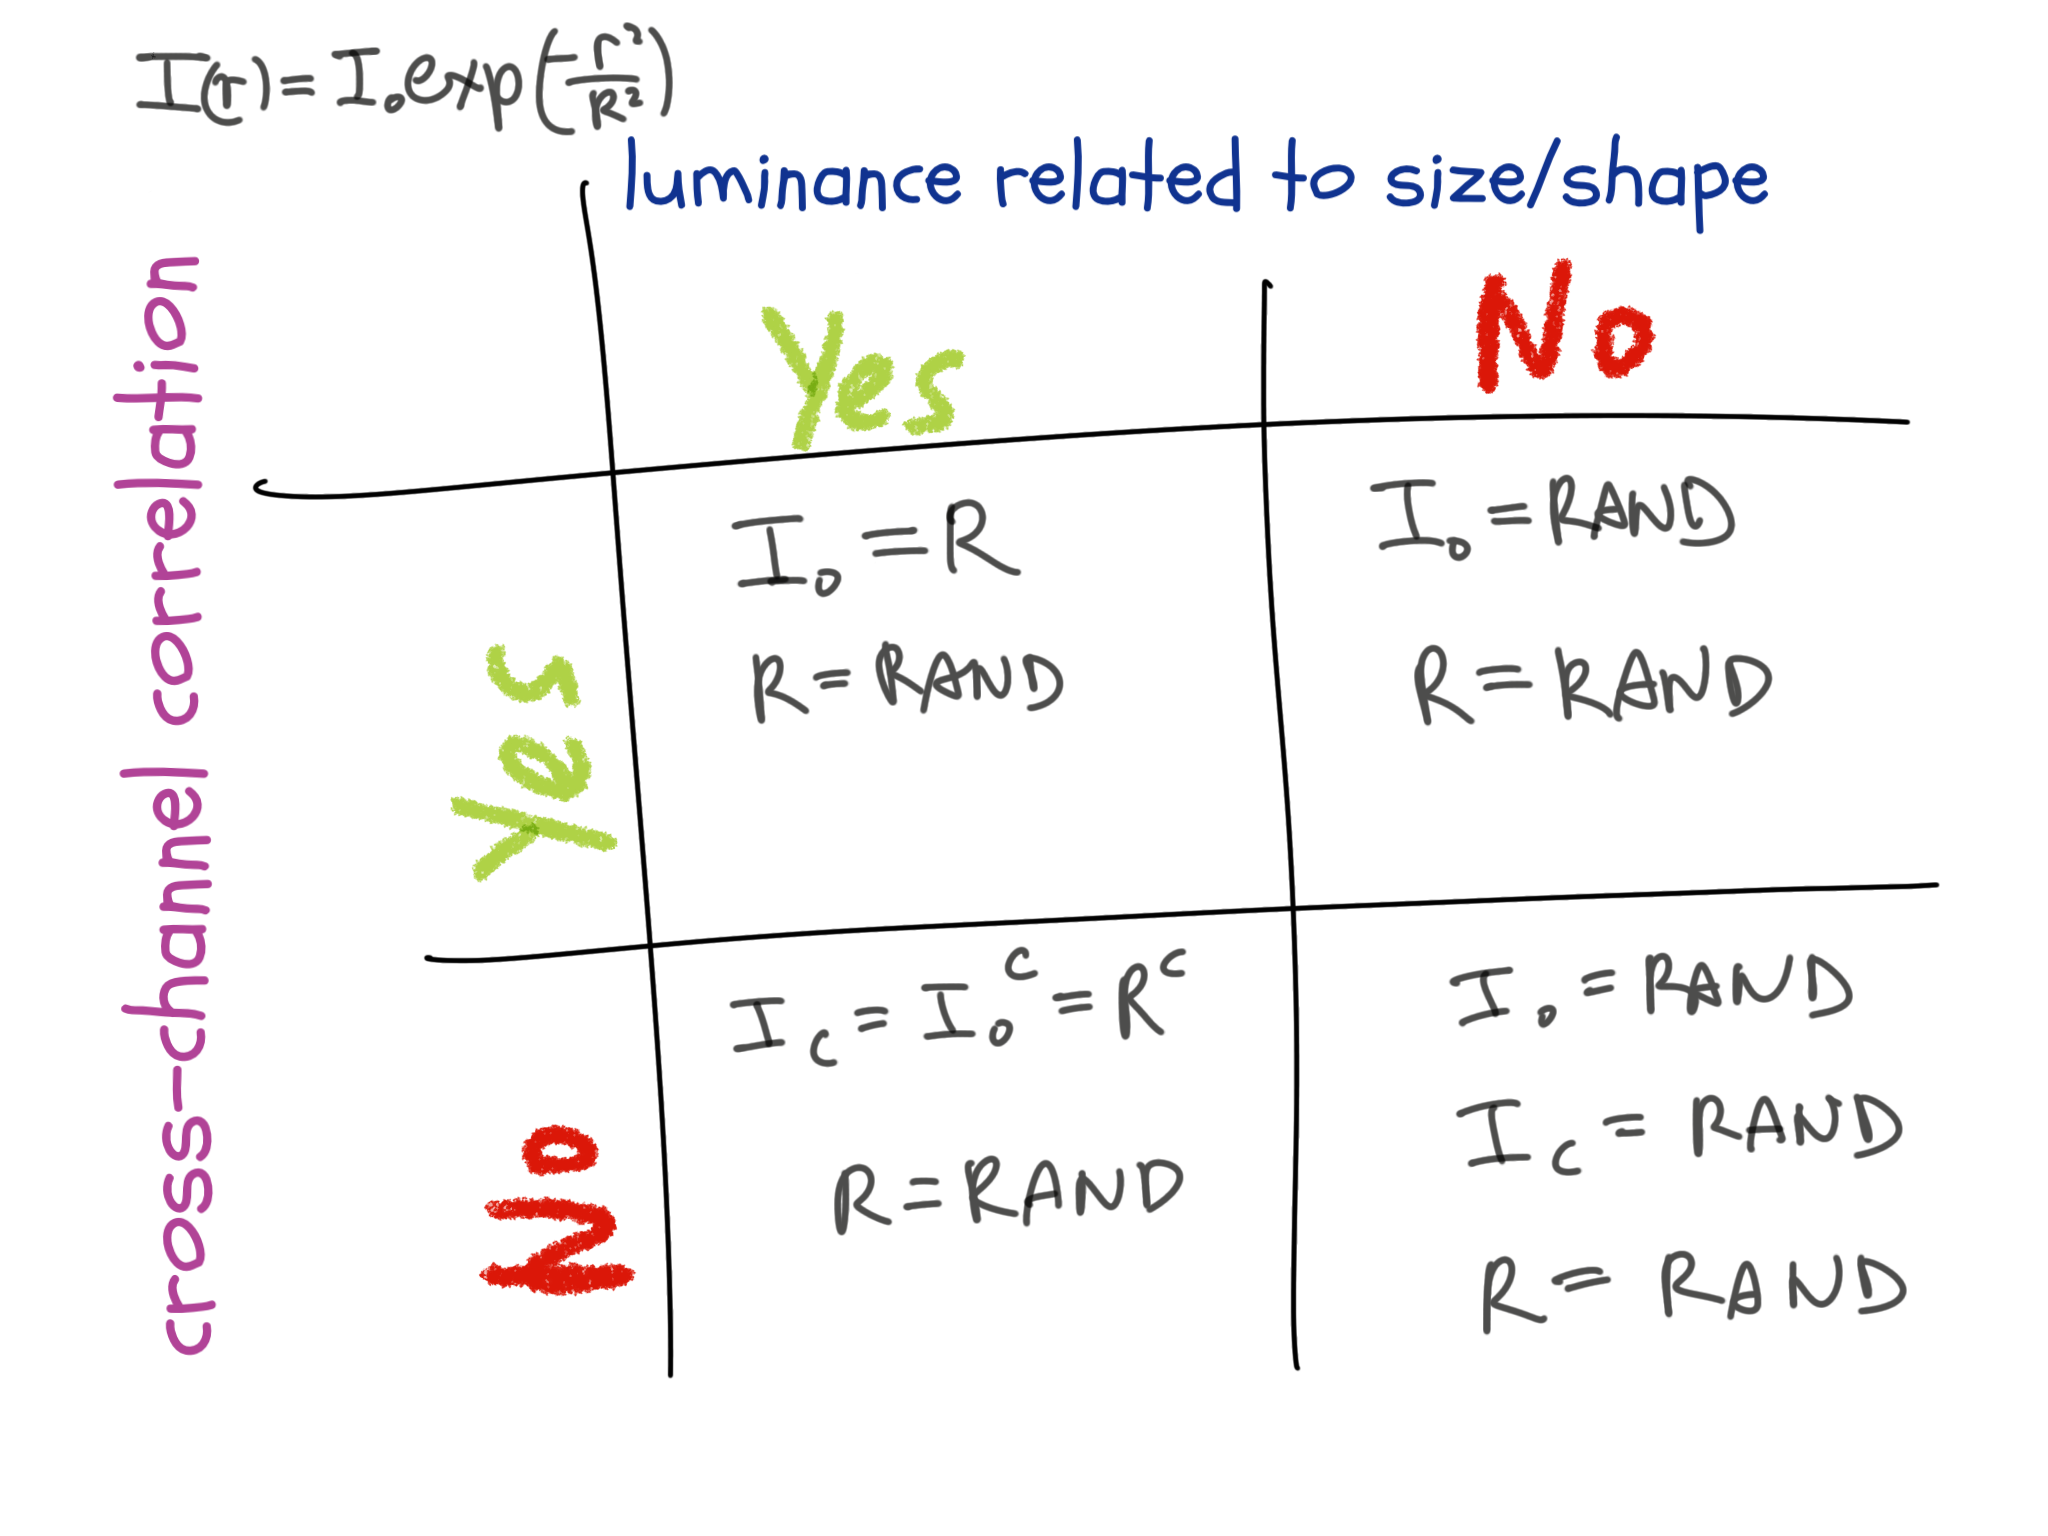

In [22]:
from IPython.display import Image
Image(filename='experiment_quadrants.png')

In [15]:
# How many times to run each experiment.
experiments_count = 1

## Experiment in the top-left cell. There is Cross-Channel correlation and Luminance is related to size/shape.

In [11]:
def make_sun_upperleft(num_channels):
    size = 28
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    for c in range(num_channels):
        I_c = R**(c/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)
    image = torch.cat([torch.from_numpy(channel).float().to(device) for channel in channels]).view(num_channels, 28, 28)
    return image

means = np.zeros((experiments_count,), dtype=np.float32)
for experiment in range(1, experiments_count + 1):
    print('\n\n----- Experiment Run {}'.format(experiment))
    means[experiment - 1] = run_experiment("upperleft_mean", make_sun_upperleft,debug_out=False) #Set debug_out=True to see samples of the toy Sun

print('\n\nFinal mean after {} runs: {}'.format(experiments_count, means.mean()))
upperleft_mean = means.mean()



----- Experiment Run 1
input_channels: 5
cnn_output_dim: 512
Current loss: 0.0913577750325203
Current loss: 0.1034008264541626
Current loss: 0.07654327154159546
Current loss: 0.05894303321838379
Current loss: 0.06419536471366882
Current loss: 0.04322824999690056
Current loss: 0.05197404697537422
Current loss: 0.05333651229739189
Current loss: 0.018617575988173485
Current loss: 0.01322134304791689
Current loss: 0.028302188962697983
Current loss: 0.031129905954003334
Current loss: 0.02960606850683689
Current loss: 0.04367731884121895
Current loss: 0.015081770718097687
Current loss: 0.01709647849202156
Current loss: 0.012949089519679546
Current loss: 0.007866675034165382
Current loss: 0.0058899312280118465
Current loss: 0.0364837646484375
Current loss: 0.03163951635360718
Current loss: 0.020588401705026627
Current loss: 0.01676180586218834
Current loss: 0.014276811853051186
Current loss: 0.04191657155752182
Current loss: 0.04302675276994705
Current loss: 0.002911586780101061
Current los

## Experiment in the lower-left cell of the previous diagram. There is NO cross-channel correlation and Luminance is related to size/shape.

In [6]:
def make_sun_lowerleft(num_channels):
    size = 28
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    for c in range(num_channels):
        random_channel = np.random.randint(num_channels)
        I_c = R ** (random_channel/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)
    image = torch.cat([torch.from_numpy(channel).float().to(device) for channel in channels]).view(num_channels, 28, 28)
    return image

means = np.zeros((experiments_count,), dtype=np.float32)
for experiment in range(1, experiments_count + 1):
    print('\n\n----- Experiment Run {}'.format(experiment))
    means[experiment - 1] = run_experiment("lowerleft_mean", make_sun_lowerleft)

print('\n\nFinal mean after {} runs: {}'.format(experiments_count, means.mean()))
lowerleft_mean = means.mean()



----- Experiment Run 1
input_channels: 5
cnn_output_dim: 512
Current loss: 0.06922677159309387
Current loss: 0.06961312144994736
Current loss: 0.054807327687740326
Current loss: 0.07923974096775055
Current loss: 0.04642622917890549
Current loss: 0.0594700463116169
Current loss: 0.016917988657951355
Current loss: 0.0711243525147438
Current loss: 0.037444159388542175
Current loss: 0.025039231404662132
Current loss: 0.029074776917696
Current loss: 0.013614590279757977
Current loss: 0.03144332766532898
Current loss: 0.04383586719632149
Current loss: 0.025008097290992737
Current loss: 0.03514987230300903
Current loss: 0.03891180083155632
Current loss: 0.03536498546600342
Current loss: 0.029582198709249496
Current loss: 0.030439991503953934
Current loss: 0.034645527601242065
Current loss: 0.02032366953790188
Current loss: 0.01586952805519104
Current loss: 0.02354850247502327
Current loss: 0.0184490829706192
Current loss: 0.030492598190903664
Current loss: 0.026276033371686935
Current loss:

## Experiment in the top-right cell of the previous diagram. There is cross-channel correlation and luminance is NOT related to size/shape.

In [7]:
def make_sun_upperright(num_channels):
    size = 28
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    I_0 = np.random.rand() * 1000.
    for c in range(num_channels):
        I_c = I_0**(c/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)
    image = torch.cat([torch.from_numpy(channel).float().to(device) for channel in channels]).view(num_channels, 28, 28)
    return image

means = np.zeros((experiments_count,), dtype=np.float32)
for experiment in range(1, experiments_count + 1):
    print('\n\n----- Experiment Run {}'.format(experiment))
    means[experiment - 1] = run_experiment("upperright_mean", make_sun_upperright)

print('\n\nFinal mean after {} runs: {}'.format(experiments_count, means.mean()))
upperright_mean = means.mean()



----- Experiment Run 1
input_channels: 5
cnn_output_dim: 512
Current loss: 0.0765712782740593
Current loss: 0.1059737429022789
Current loss: 0.07782874256372452
Current loss: 0.05921696871519089
Current loss: 0.07240017503499985
Current loss: 0.041355229914188385
Current loss: 0.048635151237249374
Current loss: 0.06493006646633148
Current loss: 0.05666493624448776
Current loss: 0.0234952662140131
Current loss: 0.027211377397179604
Current loss: 0.03809904307126999
Current loss: 0.01515947561711073
Current loss: 0.016481712460517883
Current loss: 0.029352694749832153
Current loss: 0.02614155411720276
Current loss: 0.01824517920613289
Current loss: 0.019479308277368546
Current loss: 0.04191465675830841
Current loss: 0.02025655470788479
Current loss: 0.013337614946067333
Current loss: 0.04049711301922798
Current loss: 0.011936454102396965
Current loss: 0.02240028791129589
Current loss: 0.030952852219343185
Current loss: 0.01975098066031933
Current loss: 0.03427368029952049
Current loss:

## Experiment in the lower-right cell of the previous diagram. There is NO cross-channel correlation and luminance is NOT related to size/shape.

In [8]:
def make_sun_lowerright(num_channels):
    size = 28
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    for c in range(num_channels):
        random_channel = np.random.randint(num_channels)
        random_luminance = np.random.rand() * 1000. 
        I_c = random_luminance ** (random_channel/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)
    image = torch.cat([torch.from_numpy(channel).float().to(device) for channel in channels]).view(num_channels, 28, 28)
    return image

means = np.zeros((experiments_count,), dtype=np.float32)
for experiment in range(1, experiments_count + 1):
    print('\n\n----- Experiment Run {}'.format(experiment))
    means[experiment - 1] = run_experiment("lowerright_mean", make_sun_lowerright)

print('\n\nFinal mean after {} runs: {}'.format(experiments_count, means.mean()))
lowerright_mean = means.mean()



----- Experiment Run 1
input_channels: 5
cnn_output_dim: 512
Current loss: 0.06039625406265259
Current loss: 0.12421365082263947
Current loss: 0.06254603713750839
Current loss: 0.10228173434734344
Current loss: 0.06314274668693542
Current loss: 0.1150655522942543
Current loss: 0.11408214271068573
Current loss: 0.10918557643890381
Current loss: 0.06892549246549606
Current loss: 0.06825971603393555
Current loss: 0.0779995322227478
Current loss: 0.04308873042464256
Current loss: 0.0677964836359024
Current loss: 0.0721682757139206
Current loss: 0.07387714087963104
Current loss: 0.04736186936497688
Current loss: 0.08620809018611908
Current loss: 0.0571100227534771
Current loss: 0.0541725754737854
Current loss: 0.08241866528987885
Current loss: 0.06137850135564804
Current loss: 0.04617804288864136
Current loss: 0.03510366752743721
Current loss: 0.12007714807987213
Current loss: 0.07618678361177444
Current loss: 0.0672118216753006
Current loss: 0.0633297935128212
Current loss: 0.06488754600

## Print of the previous results

In [9]:
print('Cross correlation YES/Luminance related to size & shape YES: average mean {}'.format(upperleft_mean))
print('Cross correlation NO /Luminance related to size & shape YES: average mean {}'.format(lowerleft_mean))
print('Cross correlation YES/Luminance related to size & shape NO : average mean {}'.format(upperright_mean))
print('Cross correlation NO /Luminance related to size & shape NO : average mean {}'.format(lowerright_mean))

Cross correlation YES/Luminance related to size & shape YES: average mean 0.016024388372898102
Cross correlation NO /Luminance related to size & shape YES: average mean 0.02662580832839012
Cross correlation YES/Luminance related to size & shape NO : average mean 0.023455940186977386
Cross correlation NO /Luminance related to size & shape NO : average mean 0.06568918377161026
